In [1]:
import torch
from utils.config import ModelConfig
from models.unet import UNetWithCrossAttention
from models.diffusion import Diffusion
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm

from utils.SoundDataset import SoundDataset
from torch.utils.data import DataLoader

In [2]:
def load_snapshot(snapshot_path, raw_model):
    snapshot = torch.load(snapshot_path)
    raw_model.load_state_dict(snapshot["MODEL_STATE"])
    train_losses = snapshot["TRAIN_LOSSES"]
    val_losses = snapshot["VAL_LOSSES"]

    return raw_model, train_losses, val_losses

In [3]:
image_path = "data/images"
sound_path = "data/sounds"

data = SoundDataset(image_path, sound_path)

val_loader = DataLoader(data, 
                        batch_size=8,
                        pin_memory=True,
                        shuffle=False, 
                        drop_last=True)

In [4]:
from archisound import ArchiSound

device = "cuda" if torch.cuda.is_available() else "cpu"

autoencoder = ArchiSound.from_pretrained("dmae1d-ATC64-v2").to(device)

2025-05-19 19:15:08.194988: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-05-19 19:15:08.257664: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1747671308.282145   74140 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1747671308.289825   74140 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-05-19 19:15:08.348482: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instr

In [5]:
config = ModelConfig({"image_size": 128, "audio_ctx_dim": 32})

# Инициализация
diffusion = Diffusion(timesteps=1000, image_size=128, device=device)
model = UNetWithCrossAttention(config)

In [6]:
model, train_losses, val_losses = load_snapshot("result.pt", model)

/tmp/ipykernel_74140/2394094483.py:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  snapshot = torch.load(snapshot_path)


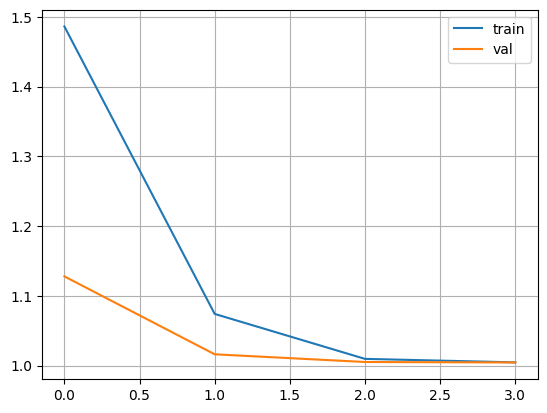

In [7]:
plt.plot(train_losses[2:], label='train')
plt.plot(val_losses[2:], label='val')
plt.grid()
plt.legend()

In [8]:
audio,image = next(iter(val_loader))
audio_embeds = autoencoder.encode(audio.to(device))
audio_embeds = audio_embeds.permute(0, 2, 1)

model.to(device)
model.eval()
generated_image = diffusion.reverse_process(
    model,
    audio_embeds,
    guidance_scale=7.5,
    batch_size=8,
    use_ddim=True,
    timesteps=100  #число шагов
)

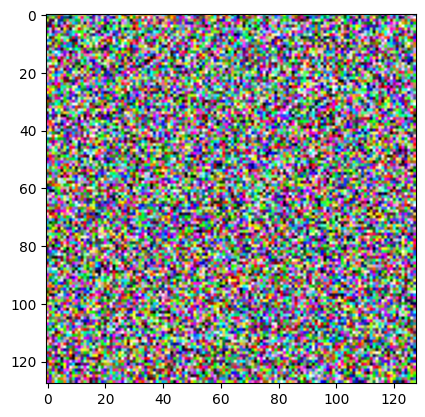

In [9]:
plt.imshow(torch.permute(generated_image[0].cpu()*0.5+0.5, (1,2,0)).numpy())